## Multi-label prediction with Planet Amazon dataset

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *

## Getting the data

TY - You can use the python package for kaggle. Or you can just download directly. If you want to know how to do the package method, refer to the original copy.

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [5]:
Config.data_path()

WindowsPath('C:/Users/kting/.fastai/data')

In [6]:
path = Config.data_path()/'planet'

In [7]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


TY - Cos this is multi-label. So we cannot rely on separation by folders to help us out (i.e. using .from_folder()). 

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [8]:
data = ImageDataBunch.from_csv(path = path, 
                               csv_labels = 'train_v2.csv',
                               folder='train-jpg', 
                               size=128, 
                               bs = 32,
                               suffix='.jpg', 
                               label_delim = ' ', 
                               ds_tfms=get_transforms(flip_vert=True,   # By default it's False. Set it True to generalise better.
                                                      max_lighting=0.1, 
                                                      max_zoom=1.05, 
                                                      max_warp=0.))     # It's like the angle of perspective; distortion. We don't want that.

TY - The following cell is equivalent as the one above. Just broken down into many steps.

For other forms of classification data types, see here for in-depth guide:

https://github.com/fastai/fastai/blob/master/docs_src/data_block.ipynb

In [9]:
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
# np.random.seed(42)
# src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
#        .split_by_rand_pct(0.2)
#        .label_from_df(label_delim=' '))
# data = (src.transform(tfms, size=128)
#         .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

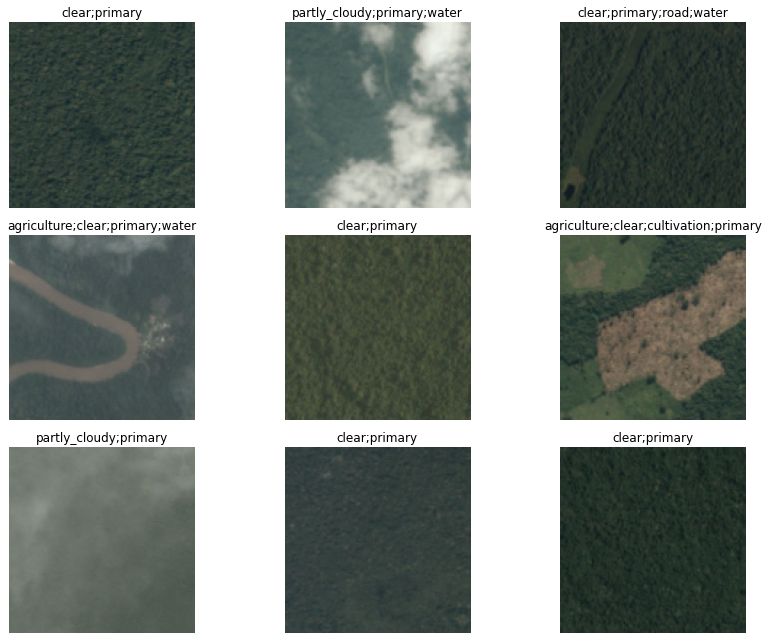

In [10]:
data.show_batch(rows=3, figsize=(12,9))

In [12]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

## Learning

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [14]:
arch = models.resnet34

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


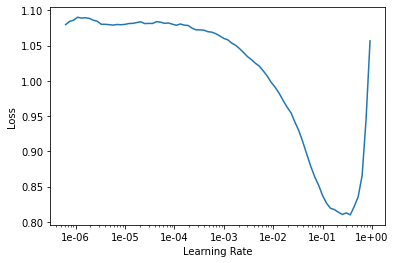

In [17]:
learn.recorder.plot()

Then we can fit the head of our network.

Note that you don't want to select your learning rate to be right on the minima. You want to go 10x less than that.

In [18]:
lr = 0.01

In [19]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.145565,0.122707,0.937914,0.897290,04:24
1,0.126835,0.103260,0.953334,0.909843,03:59
2,0.108114,0.095729,0.947724,0.917923,03:59
3,0.101261,0.090875,0.953886,0.921162,04:20
4,0.103459,0.090392,0.955492,0.923409,04:21


In [20]:
learn.save('stage-1-rn34')

In [22]:
learn.load('stage-1-rn34')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,haze;primary;water
Path: C:\Users\kting\.fastai\data\planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
agriculture;partly_cloudy;primary;road,clear;primary,clear;primary,clear;primary,clear;primary
Path: C:\Users\kting\.fastai\data\planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): 

...And fine-tune the whole model:

In [23]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


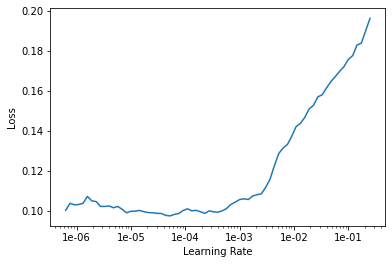

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.104697,0.094042,0.955572,0.920438,04:28
1,0.104516,0.092551,0.956560,0.922037,04:37
2,0.099667,0.087839,0.949759,0.924476,04:42
3,0.089174,0.084634,0.958086,0.927377,04:39
4,0.085331,0.083786,0.958319,0.927997,04:26


In [28]:
learn.save('stage-2-rn34')

When I created my dataset, I put size=128 and actually the images that Kaggle gave us are 256. I used the size of 128 partially because I wanted to experiment quickly. It's much quicker and easier to use small images to experiment. But there's a second reason. I now have a model that's pretty good at recognizing the contents of 128 by 128 satellite images. So what am I going to do if I now want to create a model that's pretty good at 256 by 256 satellite images? Why don't I use transfer learning? Why don't I start with the model that's good at 128 by 128 images and fine-tune that? So don't start again. That's actually going to be really interesting because if I trained quite a lot and I'm on the verge of overfitting then I'm basically creating a whole new dataset effectively﹣one where my images are twice the size on each axis right so four times bigger. So it's really a totally different data set as far as my convolutional neural networks concerned. So I got to lose all that overfitting. I get to start again. Let's keep our same learner but use a new data bunch where the data bunch is 256 by 256.

In [29]:
data = ImageDataBunch.from_csv(path = path, 
                               csv_labels = 'train_v2.csv',
                               folder='train-jpg', 
                               size=256, 
                               bs = 32,
                               suffix='.jpg', 
                               label_delim = ' ', 
                               ds_tfms=get_transforms(flip_vert=True,   # By default it's False. Set it True to generalise better.
                                                      max_lighting=0.1, 
                                                      max_zoom=1.05, 
                                                      max_warp=0.))     # It's like the angle of perspective; distortion. We don't want that.

In [30]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [31]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


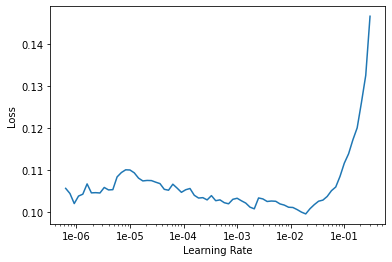

In [32]:
learn.lr_find()
learn.recorder.plot()

Because I actually now have a pretty good model (it's pretty good for 128 by 128 so it's probably gonna be like at least okay for 256 by 256), I don't get that same sharp shape that I did before. But I can certainly see where it's way too high. So I'm gonna pick something well before where it's way too high. Again maybe 10x smaller. So here I'm gonna go `1e-2/2` ﹣ that seems well before it shoots up.

In [33]:
lr=1e-2/2

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097917,0.086048,0.955848,0.925367,05:03
1,0.095547,0.084857,0.957003,0.926940,04:51
2,0.090539,0.083703,0.960244,0.927705,04:46
3,0.087850,0.082535,0.958972,0.927319,04:58
4,0.089899,0.081673,0.959002,0.928697,05:14


In [35]:
learn.save('stage-1-256-rn34')

In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087768,0.084494,0.958892,0.925599,06:21
1,0.094321,0.085972,0.958347,0.922762,06:04
2,0.087688,0.084288,0.959808,0.926180,05:56
3,0.080204,0.082255,0.960498,0.928978,06:06
4,0.083164,0.081680,0.959466,0.929357,05:51


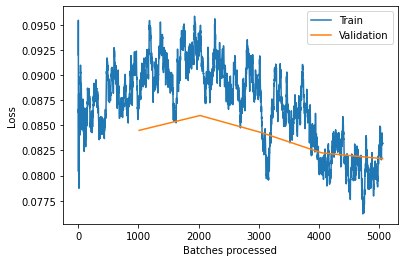

In [38]:
learn.recorder.plot_losses()

In [39]:
learn.save('stage-2-256-rn34')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

Simply call Learner.save and Learner.load to save and load models. Only the parameters are saved, not the actual architecture (so you'll need to create your model in the same way before loading weights back in). Models are saved to the path/model_dir directory.

In [40]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [41]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [43]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [44]:
learn = load_learner(path, test=test) # different from save/load. This is after exporting.
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [47]:
preds;

In [48]:
# https://www.geeksforgeeks.org/enumerate-in-python/

thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [49]:
labelled_preds[:5]

['clear primary',
 'clear primary',
 'partly_cloudy primary',
 'agriculture clear cultivation primary road water',
 'agriculture clear primary road']

In [50]:
learn.data.test_ds.items

array([WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg/test_0.jpg'),
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg/test_1.jpg'),
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg/test_10.jpg'),
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg/test_100.jpg'), ...,
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg-additional/file_9996.jpg'),
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg-additional/file_9997.jpg'),
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg-additional/file_9998.jpg'),
       WindowsPath('C:/Users/kting/.fastai/data/planet/test-jpg-additional/file_9999.jpg')], dtype=object)

In [51]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [52]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags']) # follow sample submission csv

In [53]:
df

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_10,partly_cloudy primary
3,test_100,agriculture clear cultivation primary road water
4,test_1000,agriculture clear primary road
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary
61189,file_9998,cloudy


In [54]:
df.to_csv(path/'submission.csv', index=False)

In [55]:
# ! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

TY - Private Leaderboard score: 0.92926 (around 80th). But it's from Apr 21st 2017, just so you know.